In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:

training_letter = pd.read_csv('emnist/emnist-letters-train.csv')
testing_letter = pd.read_csv('emnist/emnist-letters-test.csv')

In [3]:
y_train = np.array(training_letter.iloc[:,0].values)
x_train = np.array(training_letter.iloc[:,1:].values)

y_test = np.array(testing_letter.iloc[:,0].values)
x_test = np.array(testing_letter.iloc[:,1:].values)

In [4]:
letter_counts = training_letter.iloc[:, 0].value_counts().sort_index()

print("Количество изображений для каждой буквы:")
for letter, count in zip(range(1, 27), letter_counts):
    print(f"{chr(letter + 96)}: {count}")

Количество изображений для каждой буквы:
a: 3396
b: 3396
c: 3419
d: 3398
e: 3437
f: 3394
g: 3385
h: 3424
i: 3428
j: 3402
k: 3438
l: 3415
m: 3402
n: 3365
o: 3408
p: 3430
q: 3435
r: 3419
s: 3392
t: 3436
u: 3419
v: 3422
w: 3422
x: 3437
y: 3453
z: 3427


In [5]:
import cv2

def rotate_image(img):
    return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

def mirror_image(img):
    return np.fliplr(img)

def preprocess_dataset(dataset):
    processed_dataset = []
    for img in dataset:
        rotated_img = rotate_image(img)
        mirrored_img = mirror_image(rotated_img)
        processed_dataset.append(mirrored_img)
    return np.array(processed_dataset)

x_train_processed = preprocess_dataset(x_train)
x_test_processed = preprocess_dataset(x_test)

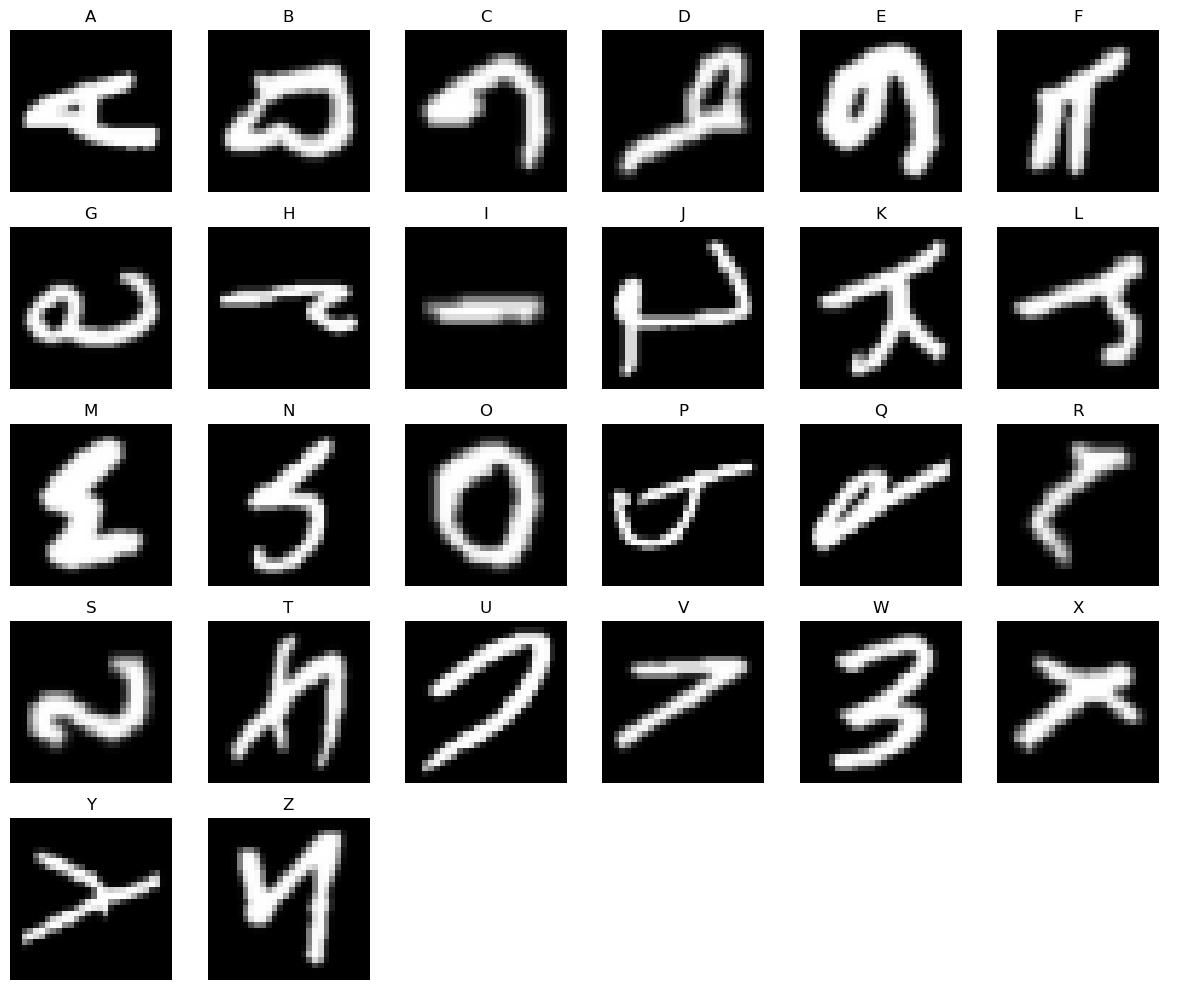

In [6]:
import numpy as np
import matplotlib.pyplot as plt

target_letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
                  'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
                  'u', 'v', 'w', 'x', 'y', 'z']

indices = {letter: np.where(y_train == ord(letter) - 96)[0] for letter in target_letters}

num_rows = 5
num_cols = 6
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    if i < len(target_letters):
        letter = target_letters[i]
        if len(indices[letter]) > 0:
            ax.imshow(x_train[indices[letter][12]].reshape((28, 28)), cmap='gray')
            ax.set_title(letter.upper())
            ax.axis('off')
        else:
            ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(x_test)
y_test_tensor = torch.tensor(y_test)

batch_size = 64

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 37)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Эпоха %d, Потеря: %.3f, Точность на тесте: %.2f%%' %
          (epoch + 1, running_loss / len(train_loader), 100 * correct / total))

Эпоха 1, Потеря: 0.616, Точность на тесте: 88.24%
Эпоха 2, Потеря: 0.293, Точность на тесте: 89.92%
Эпоха 3, Потеря: 0.240, Точность на тесте: 90.71%
Эпоха 4, Потеря: 0.208, Точность на тесте: 90.74%
Эпоха 5, Потеря: 0.187, Точность на тесте: 91.49%
Эпоха 6, Потеря: 0.165, Точность на тесте: 91.75%
Эпоха 7, Потеря: 0.150, Точность на тесте: 91.61%
Эпоха 8, Потеря: 0.137, Точность на тесте: 91.27%
Эпоха 9, Потеря: 0.124, Точность на тесте: 91.72%
Эпоха 10, Потеря: 0.115, Точность на тесте: 91.66%


In [32]:
import numpy as np

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    
    kernel = np.ones((7, 7), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=3)
    
    return binary

def segment_words(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    word_bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    
    sorted_boxes = sorted(word_bounding_boxes, key=lambda x: (x[0], x[1]))
    
    rows = []
    for box in sorted_boxes:
        x, y, w, h = box
        placed = False
        for index, (top, bottom, row_value) in enumerate(rows):
            if (y >= top and y <= bottom) or (y + h <= bottom and y <= top) or (y >= top and y + h <= bottom) or (y + h >= bottom and y <= top):
                row_value.append(box)
                placed = True
                break
        if not placed:
            inserted = False
            for index, (top, bottom, row_value) in enumerate(rows):
                if y + h <= top:
                    rows.insert(index, (y, y + h, [box]))
                    inserted = True
                    break
            if not inserted:
                rows.append((y, y + h, [box]))
                
    return [row_value for top, bottom, row_value in rows]

def segment_letters(word_image):
    gray = cv2.cvtColor(word_image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    letter_bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    sorted_boxes = sorted(letter_bounding_boxes, key=lambda x: (x[1], x[0]))
    return sorted_boxes

def predict_letter(letter_image):
    section_image_flipped = cv2.flip(letter_image, 1)
    section_image_rotated = cv2.rotate(section_image_flipped, cv2.ROTATE_90_COUNTERCLOCKWISE)
    section_image_resized = cv2.resize(section_image_rotated, (28, 28))
    section_image_normalized = section_image_resized.astype('float32') / 255
    gray_section_image = cv2.cvtColor(section_image_normalized, cv2.COLOR_BGR2GRAY)
    input_tensor = torch.tensor(gray_section_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    plt.figure(figsize=(1, 1))
    plt.imshow(gray_section_image, cmap='gray')
    plt.title('===')
    plt.axis('off')
    plt.show()
    
    with torch.no_grad():
        output = model(input_tensor)
        prediction = output.argmax(dim=1).item()
    return prediction

def add_black_border(image, border_size=35, color=(0, 0, 0)):
    height, width = image.shape[:2]
    bordered_image = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=color)
    return bordered_image

def recognize_words(image):
    binary_image = preprocess_image(image)
    rows = segment_words(binary_image)
    recognized_words = []
    for row in rows:
        row_words = []
        for bbox in row:
            x, y, w, h = bbox
            word_image = image[y:y+h, x:x+w]
            bordered_word_image = add_black_border(word_image)
            letter_bounding_boxes = segment_letters(bordered_word_image)
            recognized_word = ''
            for letter_bbox in letter_bounding_boxes:
                x, y, w, h = letter_bbox
                letter_image = bordered_word_image[y:y+h, x:x+w]
                predicted_letter = predict_letter(letter_image)
                alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
                predicted_letter -= 1
                recognized_word += alphabet[predicted_letter]
            row_words.append(recognized_word)
        recognized_words.append(row_words)
    return recognized_words

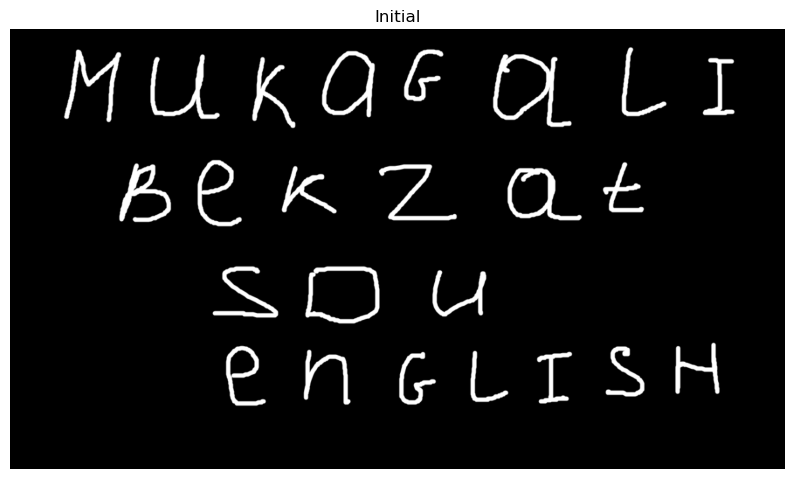

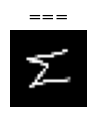

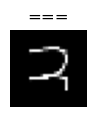

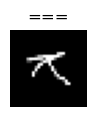

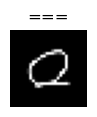

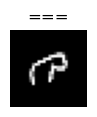

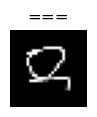

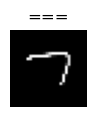

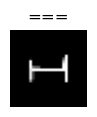

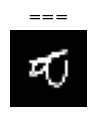

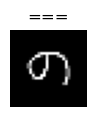

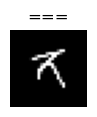

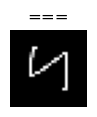

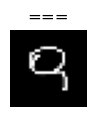

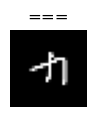

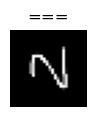

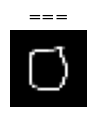

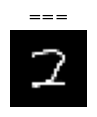

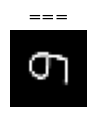

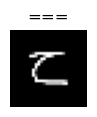

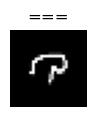

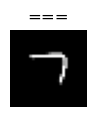

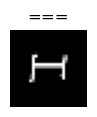

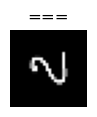

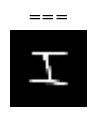

MUKQCALI
BEKZAT
SDU
RNCLISM


In [33]:
image_path = 'source/image.png'
word_image = cv2.imread(image_path)

plt.figure(figsize=(10, 10))
plt.imshow(word_image, cmap='gray')
plt.title('Initial')
plt.axis('off')
plt.show()

recognized_words = recognize_words(word_image)
for list_ in recognized_words:
    s = ''
    for i in list_:
        s += i
    print(s)